# Proyecto Integrador IV
> E-Commerce Data Pipeline

En este notebook, primero ejecutaremos todos los componentes de nuestro pipeline ELT y luego realizaremos visualizaciones con la información resultante


In [1]:
# Importing the necessary libraries
from pandas import DataFrame
from sqlalchemy import create_engine
from typing import Dict
from pathlib import Path

from src.transform import QueryEnum
from src import config
from src.transform import run_queries
from src.extract import extract
from src.load import load
from src.plots import (
    plot_freight_value_weight_relationship,
    plot_global_amount_order_status,
    plot_real_vs_predicted_delivered_time,
    plot_revenue_by_month_year,
    plot_revenue_per_state,
    plot_top_10_least_revenue_categories,
    plot_top_10_revenue_categories,
    plot_top_10_revenue_categories_ammount,
    plot_delivery_date_difference,
    plot_order_amount_per_day_with_holidays,
)

In [2]:
# Create the database sql file
Path(config.SQLITE_BD_ABSOLUTE_PATH).touch()

# Create the database connection
ENGINE = create_engine(rf"sqlite:///{config.SQLITE_BD_ABSOLUTE_PATH}", echo=False)


### 1. Extract

Aquí estarás extrayendo la información de las fuentes.

In [3]:
csv_folder = config.DATASET_ROOT_PATH
public_holidays_url = config.PUBLIC_HOLIDAYS_URL

# 1. Get the mapping of the csv files to the table names.
csv_table_mapping = config.get_csv_to_table_mapping()

# 2. Extract the data from the csv files, holidays and load them into the dataframes.
csv_dataframes = extract(csv_folder, csv_table_mapping, public_holidays_url)

In [4]:
csv_dataframes["olist_products"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [5]:

for nombre_df, df in csv_dataframes.items():
    # Identificar las columnas de tipo int64
    columnas_int = df.select_dtypes(include=['int64']).columns
    
    # Convertir cada columna int64 a string
    for col in columnas_int:
        df[col] = df[col].astype('Float64')
csv_dataframes["olist_customers"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               99441 non-null  object 
 1   customer_unique_id        99441 non-null  object 
 2   customer_zip_code_prefix  99441 non-null  Float64
 3   customer_city             99441 non-null  object 
 4   customer_state            99441 non-null  object 
dtypes: Float64(1), object(4)
memory usage: 3.9+ MB


### 2. Load

Usando los diferentes conjuntos de datos proporcionados, almacenarás todo en nuestro Data Warehouse.

In [6]:
load(data_frames=csv_dataframes, database=ENGINE)

In [8]:
import pandas as pd
tables_df = pd.read_sql_query(
    "SELECT name FROM sqlite_master WHERE type='table';",
    ENGINE
)

tables_df

,name
0,olist_customers
1,olist_geolocation
2,olist_order_items
3,olist_order_payments
4,olist_order_reviews
5,olist_orders
6,olist_products
7,olist_sellers
8,product_category_name_translation
9,public_holidays


In [9]:
testquery = "SELECT * FROM public_holidays LIMIT 5"
testdf = pd.read_sql_query(testquery, ENGINE)
testdf

,date,localName,name,countryCode,fixed,global,launchYear
0,2017-01-01 00:00:00.000000,Confraternização Universal,New Year's Day,BR,0,1,None
1,2017-02-27 00:00:00.000000,Carnaval,Carnival,BR,0,1,None
2,2017-02-28 00:00:00.000000,Carnaval,Carnival,BR,0,1,None
3,2017-04-14 00:00:00.000000,Sexta-feira Santa,Good Friday,BR,0,1,None
4,2017-04-16 00:00:00.000000,Domingo de Páscoa,Easter Sunday,BR,0,1,None


### 3. Transform

Aquí transformarás las diferentes consultas en tablas. Hay dos secciones: una con las consultas relacionadas con los ingresos y otra con las consultas relacionadas con las entregas.

##### 3.1 Queries sobre ingresos

In [10]:
query_results: Dict[str, DataFrame] = run_queries(database=ENGINE)

In [11]:
# Transforming the revenue_by_month_year query to a table
revenue_by_month_year = query_results[QueryEnum.REVENUE_BY_MONTH_YEAR.value]
revenue_by_month_year

,month_no,month,Year2016,Year2017,Year2018
0,01,Jan,0.00,38708.63,993588.74
1,02,Feb,0.00,228152.25,875514.19
2,03,Mar,0.00,387275.32,1043754.61
3,04,Apr,0.00,307722.84,1300791.67
4,05,May,0.00,600917.76,1170501.14
5,06,Jun,0.00,502197.97,1171086.67
6,07,Jul,0.00,531271.71,948000.64
7,08,Aug,0.00,627367.19,1347216.73
8,09,Sep,0.00,670205.77,12875.18
9,10,Oct,34438.41,759903.98,347.95


In [12]:
# Transforming the top_10_revenue_categories query to a table
top_10_revenue_categories = query_results[QueryEnum.TOP_10_REVENUE_CATEGORIES.value]
top_10_revenue_categories

,Category,Num_order,Revenue
0,bed_bath_table,9272,1692714.28
1,health_beauty,8646,1620684.04
2,computers_accessories,6529,1549252.47
3,furniture_decor,6307,1394466.93
4,watches_gifts,5493,1387046.31
5,sports_leisure,7529,1349252.93
6,housewares,5743,1069787.97
7,auto,3809,833610.84
8,garden_tools,3448,810614.93
9,cool_stuff,3559,744649.32


In [13]:
# Transforming the top_10_least_revenue_categories query to a table
top_10_least_revenue_categories = query_results[
    QueryEnum.TOP_10_LEAST_REVENUE_CATEGORIES.value
]
top_10_least_revenue_categories

,Category,Num_order,Revenue
0,security_and_services,2,324.51
1,fashion_childrens_clothes,7,718.98
2,cds_dvds_musicals,12,1199.43
3,home_comfort_2,24,1710.54
4,flowers,29,2213.01
5,arts_and_craftmanship,23,2326.17
6,la_cuisine,13,2913.53
7,fashion_sport,26,3605.83
8,diapers_and_hygiene,25,4126.17
9,fashio_female_clothing,36,4902.67


In [14]:
# Transforming the revenue_per_state query to a table
revenue_per_state = query_results[QueryEnum.REVENUE_PER_STATE.value]
revenue_per_state

,customer_state,Revenue
0,SP,5769081.27
1,RJ,2055690.45
2,MG,1819277.61
3,RS,861608.40
4,PR,781919.55
5,SC,595208.40
6,BA,591270.60
7,DF,346146.17
8,GO,334294.22
9,ES,317682.65


##### 3.2 Queries sobre entregas

In [15]:
# Transforming the delivery_date_difference query to a table
delivery_date_difference = query_results[QueryEnum.DELIVERY_DATE_DIFFERECE.value]
delivery_date_difference

,State,Delivery_Difference
0,AL,8
1,MA,9
2,BA,10
3,CE,10
4,ES,10
5,SE,10
6,MS,11
7,PI,11
8,RJ,11
9,SC,11


In [16]:
# Transforming the real vs predicted delivered time query to a table per month and year
real_vs_estimated_delivered_time = query_results[
    QueryEnum.REAL_VS_ESTIMATED_DELIVERED_TIME.value
]
real_vs_estimated_delivered_time

,month_no,month,Year2016_real_time,Year2017_real_time,Year2018_real_time,Year2016_estimated_time,Year2017_estimated_time,Year2018_estimated_time
0,01,Jan,0.000000,12.647044,14.080563,0.000000,39.508831,26.302555
1,02,Feb,0.000000,13.168825,16.945138,0.000000,31.848929,24.528996
2,03,Mar,0.000000,12.951184,16.301410,0.000000,24.732386,22.033067
3,04,Apr,0.000000,14.917913,11.499241,0.000000,27.349810,23.679546
4,05,May,0.000000,11.322363,11.419029,0.000000,24.284784,22.891488
5,06,Jun,0.000000,12.011573,9.239216,0.000000,24.021864,27.772740
6,07,Jul,0.000000,11.592732,8.958636,0.000000,23.317316,19.690127
7,08,Aug,0.000000,11.147125,7.732780,0.000000,23.480603,15.186330
8,09,Sep,54.813194,11.851007,0.000000,18.488449,22.437366,0.000000
9,10,Oct,19.600559,11.856700,0.000000,55.676632,23.019536,0.000000


In [17]:
# Transforming the global ammount of order status query to a table
global_ammount_order_status = query_results[QueryEnum.GLOBAL_AMMOUNT_ORDER_STATUS.value]
global_ammount_order_status

,order_status,Ammount
0,approved,2
1,canceled,625
2,created,5
3,delivered,96478
4,invoiced,314
5,processing,301
6,shipped,1107
7,unavailable,609


In [18]:
orders_per_day_and_holidays = query_results[
    QueryEnum.ORDERS_PER_DAY_AND_HOLIDAYS_2017.value
]
orders_per_day_and_holidays

,date,order_count,holiday
0,2017-01-05,32,False
1,2017-01-06,4,False
2,2017-01-07,4,False
3,2017-01-08,6,False
4,2017-01-09,5,False
...,...,...,...
356,2017-12-27,167,False
357,2017-12-28,146,False
358,2017-12-29,135,False
359,2017-12-30,97,False


In [19]:
freight_value_weight_relationship = query_results[
    QueryEnum.GET_FREIGHT_VALUE_WEIGHT_RELATIONSHIP.value
]

### 4. Graficas de las tablas resultantes

Ahora, crearemos gráficos a partir de las diferentes consultas.

In [ ]:
plot_revenue_by_month_year(revenue_by_month_year, 2017)

In [21]:
plot_top_10_revenue_categories(top_10_revenue_categories)

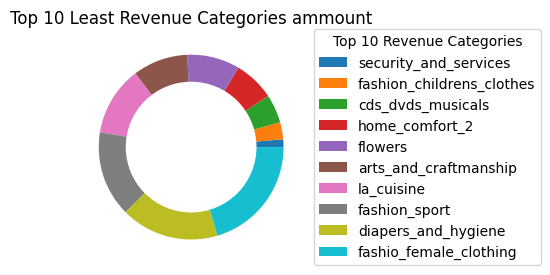

In [22]:
plot_top_10_least_revenue_categories(top_10_least_revenue_categories)

In [23]:
plot_revenue_per_state(revenue_per_state)

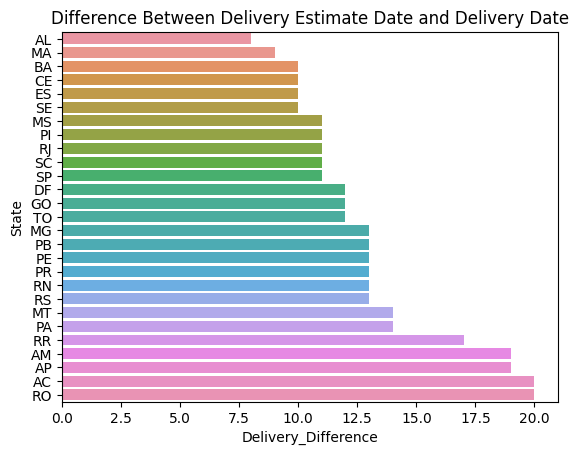

In [24]:
plot_delivery_date_difference(delivery_date_difference)

In [ ]:
plot_real_vs_predicted_delivered_time(real_vs_estimated_delivered_time, year=2017)

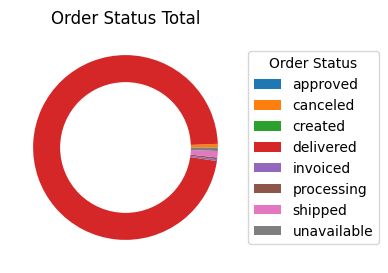

In [26]:
plot_global_amount_order_status(global_ammount_order_status)

In [ ]:
plot_order_amount_per_day_with_holidays(orders_per_day_and_holidays)

El gráfico de Pedidos por Día y Días Festivos que programarás en **src/plots.py** debe ser similar a este:

![The plot you will code will be similar to this:](images/orders_per_day_and_holidays.png "Orders per Day and Holidays")

4.1 ¿Ves alguna relación entre los días festivos en Brasil durante 2017 y las compras de ese año?

Respuesta: ________

In [ ]:
plot_freight_value_weight_relationship(freight_value_weight_relationship)

El gráfico sobre la relación entre el valor del flete y el peso del producto que debes programar en `src/plots.py` tiene que ser similar a este:

![The plot you will code will be similar to this:](images/freight_value_weight_relationship.png "Freight Value and Weight Relationship")

4.2 ¿Ves alguna correlación entre el valor del flete y el peso del producto?

Respuesta:____